# pycollimate's get_impact_pos minimal example

In [12]:
from __future__ import print_function
from __future__ import division

import copy
import numpy as np

import sys
PYCOLPATH = '/afs/cern.ch/project/sloex/code/pycollimate'
sys.path.insert(1, PYCOLPATH)

from pycollimate import Septum, Proton, get_impact_pos

%matplotlib notebook

In [2]:
def createProtons(s, x, px):
    protons = [Proton(
        s = ss,
        x = xx,
        x_p = pp,
        y = 0,
        y_p = 0,
        pt = 0,
        p0 = 400,
        t = 0,
        flag = 'outside',
        id = k,
    ) for k, (ss, xx, pp) in enumerate(zip(s, x, px))]
    
    return protons


def getFlags(protons, septum):
    coords = []
    flags = []
    
    for p in protons:
        s0, x0, p0 = map(copy.deepcopy, (p.s, p.x, p.x_p))
        coords.append((s0, x0, p0))
        get_impact_pos(septum, p)
        flags.append(p.flag)
    
    result = pd.DataFrame(coords, columns = ['S', 'X', 'PX'])
    result['flag'] = flags
    
    return result


def generateDistribution(N, sigma_x, sigma_px, rho):
    mu = np.array([0, 0])
    sigma = np.array([[sigma_x ** 2, - rho * sigma_x * sigma_px], [- rho * sigma_x * sigma_px, sigma_px ** 2]])
    
    x, p = np.random.multivariate_normal(mu, sigma, N).T
    
    return x, p

Create two Septum objects with identical parameters except for the inclination

In [3]:
s0 = 1000 # ZS upstream S
length = 20 # ZS length
kick = 5e-4 # ZS deflection
w = 100e-6 # wire thickness
theta = -1.5e-3 # ZS inclination in rad

# horizontal septum, theta = 0
septum_h = Septum(
    material = 'W75RE25',
    s0 = s0,
    length = length,
    aper_u = 0,
    aper_d = 0,
    unc_u = 0,
    unc_d = 0,
    thickness = w,
    name = 'horizontal',
    side = 'left',
    kick = kick,
    eff_dens = 1.,
)

# Inclination of theta rad
septum_i = Septum(
    material = 'W75RE25',
    s0 = s0,
    length = length,
    aper_u = 0,
    aper_d = theta * length,
    unc_u = 0,
    unc_d = 0,
    thickness = w,
    name = 'inclined',
    side = 'left',
    kick = kick,
    eff_dens = 1.,
)

Now generate a particle distribution centered at (0, 0) in phase space. Scattering this distribution through the horizontal septum should have the same effect as scattering the same distribution transported to (0, $\theta$) through the inclined septum.

In [4]:
# Create distribution centered around (0, 0) in phase space
N = 10000
sigma_x, sigma_px = 2.5e-3, 1e-4
rho = .4

xh, ph = generateDistribution(N, sigma_x, sigma_px, rho)

xi = copy.deepcopy(xh)
pi = copy.deepcopy(ph) + theta

Sanity check: phase space looks identical except for the offset in PX.

In [5]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(1e3 * xh, 1e3 * ph, s = 3, alpha = .75)
ax[0].axhline(0, ls = '--', c = 'k')
ax[0].axvspan(0, 1e3 * w, color = 'gray', alpha = .5)

ax[1].scatter(1e3 * xi, 1e3 * pi, s = 3, alpha = .75)
ax[1].axhline(1e3 * theta, ls = '--', c = 'k', label = r'$\theta$')
ax[1].axvspan(0, 1e3 * w, color = 'gray', alpha = .5, label = 'Wire')

ax[0].set_xlabel('X [mm]')
ax[0].set_ylabel('PX [mrad]')

plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

Call ``get_impact_pos`` to update particle flags.

In [6]:
# Create proton universe
protons_h = createProtons([s0] * N, xh, ph)
protons_i = createProtons([s0] * N, xi, pi)

In [7]:
# Define dataframes
hor = getFlags(protons_h, septum_h)
inc = getFlags(protons_i, septum_i)

Plot results. Both cases should look the same, and they do with the correct definition of eq_c in get_im

<IPython.core.display.Javascript object>


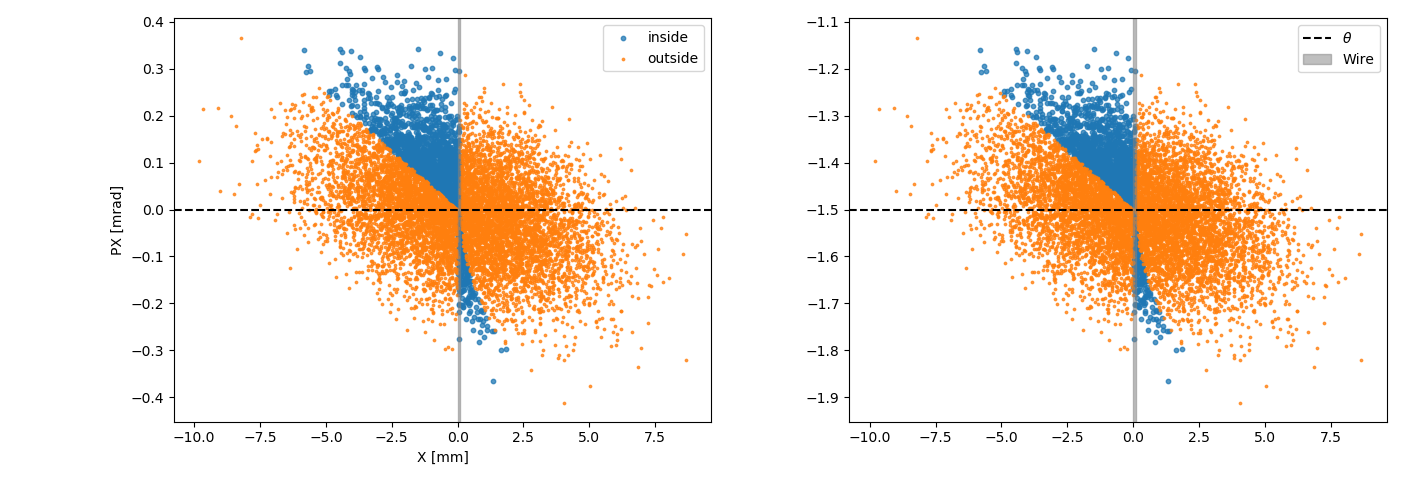

In [8]:
# Repeat plot, labelling by flag

fig, ax = plt.subplots(1, 2)

for k, val in hor.groupby('flag').groups.iteritems():
    ax[0].scatter(1e3 * hor.loc[val, 'X'].values, 1e3 * hor.loc[val, 'PX'].values, s = 3 if k == 'outside' else 10, alpha = .75, label = k)

ax[0].axhline(0, ls = '--', c = 'k')
ax[0].axvspan(0, 1e3 * w, color = 'gray', alpha = .5)

ax[0].legend()

for k, val in inc.groupby('flag').groups.iteritems():
    ax[1].scatter(1e3 * inc.loc[val, 'X'].values, 1e3 * inc.loc[val, 'PX'].values, s = 3 if k == 'outside' else 10, alpha = .75)

ax[1].axhline(1e3 * theta, ls = '--', c = 'k', label = r'$\theta$')
ax[1].axvspan(0, 1e3 * w, color = 'gray', alpha = .5, label = 'Wire')

ax[0].set_xlabel('X [mm]')
ax[0].set_ylabel('PX [mrad]')

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
assert all(hor[hor.flag == 'inside'] == inc[inc.flag == 'inside'])